In [4]:
#!pip install GPUtil
import torch
from GPUtil import showUtilization as gpu_usage
from numba import cuda

def free_gpu_cache():
    print("Initial GPU Usage")
    gpu_usage()                             

    torch.cuda.empty_cache()

    cuda.select_device(0)
    cuda.close()
    cuda.select_device(0)

    print("GPU Usage after emptying the cache")
    gpu_usage()

free_gpu_cache()


Initial GPU Usage
| ID | GPU | MEM |
------------------
|  0 |  1% |  2% |
GPU Usage after emptying the cache
| ID | GPU | MEM |
------------------
|  0 |  9% |  2% |


In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import HTML

import string
import re

import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation, NMF
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix,accuracy_score, f1_score, precision_score, recall_score

import random
import warnings
import time
import datetime

from matplotlib.ticker import MaxNLocator
import matplotlib.gridspec as gridspec
import matplotlib.patches as mpatches

from transformers import BertTokenizer, BertForSequenceClassification, AdamW, BertConfig, get_linear_schedule_with_warmup
from torch.utils.data import TensorDataset, random_split, DataLoader, RandomSampler, SequentialSampler

plt.style.use('fivethirtyeight')
warnings.filterwarnings('ignore')

seed_val = 42
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /usr/share/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.0/12.0 MB 61.8 MB/s eta 0:00:0000:010:01
  Preparing metadata (setup.py) ... done
  Created wheel for en-core-web-sm: filename=en_core_web_sm-2.2.5-py3-none-any.whl size=12011718 sha256=5857a575b5763e5eebc0ca009ed732431dbb4cd53a827ef5198d4090500c5f38
  Stored in directory: /root/.cache/pip/wheels/28/45/a9/c35b2107f053046bd5ac0b1adb5ea970938b02b134e49b9a06
Successfully built en-core-web-sm
  Atte

/opt/conda/lib/python3.10/site-packages/spacy/util.py:918: UserWarning: [W094] Model 'en_core_web_sm' (2.2.5) specifies an under-constrained spaCy version requirement: >=2.2.2. This can lead to compatibility problems with older versions, or as new spaCy versions are released, because the model may say it's compatible when it's not. Consider changing the "spacy_version" in your meta.json to a version range, with a lower and upper pin. For example: >=3.7.2,<3.8.0
  warnings.warn(warn_msg)


In [6]:
train = pd.read_csv('/kaggle/input/nlp-getting-started/train.csv')
test = pd.read_csv('/kaggle/input/nlp-getting-started/test.csv')

# Text cleaning

In [7]:
display(train.sample(5))
display(test.sample(5))

,id,keyword,location,text,target
2644,3796,destruction,NaN,So you have a new weapon that can cause un-ima...,1
2227,3185,deluge,NaN,The f$&amp;@ing things I do for #GISHWHES Just...,0
5448,7769,police,UK,DT @georgegalloway: RT @Galloway4Mayor: ÛÏThe...,1
132,191,aftershock,NaN,Aftershock back to school kick off was great. ...,0
6845,9810,trauma,"Montgomery County, MD",in response to trauma Children of Addicts deve...,0


,id,keyword,location,text
142,449,armageddon,1996???????????,UNIVERSAL ORDER OF ARMAGEDDON http://t.co/3tY4mGm
2672,8915,snowstorm,Los Angeles,@BigBang_CBS ...wow...ok...um...that was like ...
2605,8682,sinkhole,"New York, New York",The sinkhole that ate Brooklyn http://t.co/28r...
2515,8381,ruin,"Monroe, OH",Don't ruin a good today by thinking about a ba...
958,3187,deluge,"West Powelton, Philadelphia",I'm havin previous life flashbacks of when i l...


In [8]:
HTML(train.sample(n=5, random_state=42).sort_values(by='id').to_html(index=False)) #using HTML/to_html to hide the index

id,keyword,location,text,target
191,aftershock,NaN,Aftershock back to school kick off was great. I want to thank everyone for making it possible. What a great night.,0
3185,deluge,NaN,The f$&amp;@ing things I do for #GISHWHES Just got soaked in a deluge going for pads and tampons. Thx @mishacollins @/@,0
3796,destruction,NaN,So you have a new weapon that can cause un-imaginable destruction.,1
7769,police,UK,DT @georgegalloway: RT @Galloway4Mayor: ÛÏThe CoL police can catch a pickpocket in Liverpool Stree... http://t.co/vXIn1gOq4Q,1
9810,trauma,"Montgomery County, MD",in response to trauma Children of Addicts develop a defensive self - one that decreases vulnerability. (3,0


In [9]:
def clean_text(df):

    # Copy the original text before processing it
    df['ori_text'] = df['text']

    # Cleaning
    # Remove user and urls from text
    df['text'] = df['text'].str.replace('@\w+', '', regex=True)
    df['text'] = df['text'].str.replace('https?://t.co/\w+', '', regex=True) 
    # hashtag : remove # from the text 
    repl = lambda h: h[0][1:]
    df['text'] = df['text'].str.replace('#\w+', repl, regex=True)
    # Force splitting words appended with slashes (once we removed the url, of course)
    df['text'] = df['text'].str.replace('/', ' / ', regex=True)
    # Replace &amp; by and
    df['text'] = df['text'].str.replace('&;', ' and ', regex=True)
     # Handle sequences like '\x89ÛÏ'
    dec = lambda t: t.encode('ascii', 'ignore').decode('utf-8')
    df['text'] = df['text'].apply(lambda text: dec(text))
      # Replace \n by point
    df['text'] = df['text'].str.replace('\n', '.', regex=True) 
     # Replace '  ' by ' '
    df['text'] = df['text'].str.replace('  ', ' ', regex=True) # multiple spaces  

    return df.copy()

In [10]:
train = clean_text(train)
test = clean_text(test)

#The output 
diff = train[train['ori_text']!=train['text']][['ori_text','text']]
HTML(diff.sample(n=5, random_state=42).to_html(index=False))

ori_text,text
Don't say @ALIPAPER: women got problems this #keepingtheviginaclean thing is very interesting n less expensive #metrofmtalk',Don't say : women got problems this keepingtheviginaclean thing is very interesting n less expensive metrofmtalk'
.@stavernise: France agreed to repay Russia for two warships which were never delivered after economic sanctions http://t.co/K4H8cq7puo,.: France agreed to repay Russia for two warships which were never delivered after economic sanctions
Economic Collapse Investing: Specific actions and strategies to securing lasting wealth from the financial blowout. http://t.co/JZwRisXEPF,Economic Collapse Investing: Specific actions and strategies to securing lasting wealth from the financial blowout.
Sure the #Megaquake story brought a sense of panic but the question is: will anything really change? http://t.co/9f3rDN9N3D,Sure the Megaquake story brought a sense of panic but the question is: will anything really change?
Souda leave Lady Sonia alone or I shall obliterate you #KneelBot,Souda leave Lady Sonia alone or I shall obliterate you KneelBot


In [11]:
# Count the number of duplicate texts and store it in a different variable
num_duplicate_texts = train['text'].duplicated().sum()
print(f"Number of duplicate texts in train dataset: {num_duplicate_texts}")


Number of duplicate texts in train dataset: 677


In [12]:
# Group by text and filter out groups that have more than one unique target
duplicate_texts = train.groupby('text').filter(lambda x: x['target'].nunique() > 1)

# Sort the result
sorted_duplicates = duplicate_texts.sort_values(by='text')

print(sorted_duplicates[['text', 'target']])

                                                   text  target
5813   Chinas stock market crash this summer has spa...       1
5814   Chinas stock market crash this summer has spa...       0
5785   Cindy Noonan-Heartbreak in Baltimore Rioting ...       1
5807   Cindy Noonan-Heartbreak in Baltimore Rioting ...       0
2046   FETTILOOTCH IS SLANGLUCCI OPPRESSIONS GREATES...       0
...                                                 ...     ...
6123  that horrible sinking feeling when youve been ...       1
591   world FedEx no longer to transport bioterror g...       0
587   world FedEx no longer to transport bioterror g...       1
5641  wowo--=== 12000 Nigerian refugees repatriated ...       0
5620  wowo--=== 12000 Nigerian refugees repatriated ...       1

[251 rows x 2 columns]


In [13]:
# Function to determine the majority label
def majority_label(group):
    most_common = group['target'].mode()
    if len(most_common) > 1:  # In case of a tie
        return group.iloc[0]['target']  # Keep the first one
    else:
        return most_common.iloc[0]

majority_labels = train.groupby('text').apply(majority_label).reset_index(name='majority_target')
train = train.merge(majority_labels, on='text', how='left')

train['target'] = train['majority_target']
train.drop(columns=['majority_target'], inplace=True)

# Drop duplicates in text column while keeping all other columns
train.drop_duplicates(subset='text', inplace=True)

In [14]:
num_duplicate_texts = train['text'].duplicated().sum()
print(f"Number of duplicate texts in train dataset: {num_duplicate_texts}")

Number of duplicate texts in train dataset: 0


In [15]:
display(train.sample(10))
display(test.sample(10))
print(f'Number of training tweets: {train.shape[0]}\n')
print(f'Number of training tweets: {test.shape[0]}\n')

,id,keyword,location,text,target,ori_text
3929,5587,flood,New York,1 pair new 27w 4'' ROUND LED Work Driving FLOO...,0,1 pair new 27w 4'' ROUND LED Work Driving FLO...
2463,3531,derailment,India,25 killed 50 injured in Madhya Pradesh twin tr...,1,25 killed 50 injured in Madhya Pradesh twin tr...
3757,5338,fire,å_,WCW THA BITCH IS FIRE,0,WCW @catsandsyrup THA BITCH IS FIRE
3983,5659,flooding,"Nadiad ,Gujarat , India!!",Thankkk U all Soo much for Flooding my Notific...,0,Thankkk U all Soo much for Flooding my Notific...
1148,1653,bombing,Toronto-Citizen of Canada & US,When push2Left talk='ecology'&amp;'human rts...,1,@rinkydnk2 @ZaibatsuNews @NeoProgressive1 When...
862,1244,blood,"Seattle, WA",Yeah you are! SpeakingFromExperience,0,@Chambered_Blood Yeah you are! #SpeakingFromEx...
4579,6512,injuries,"Alameda and Pleasanton, CA",A new type of ADHD? Head injuries in children ...,0,A new type of ADHD? Head injuries in children ...
7408,10599,wounded,"Miami,Fla",California cops have sketch of gunman who kill...,1,California cops have sketch of gunman who kill...
6895,9884,traumatised,North East / Middlesbrough,Sending a snapchat to the wrong person instead...,0,Sending a snapchat to the wrong person instead...
4805,6839,loud%20bang,NaN,he was ;-; like he was singing so loud ;-;,0,@Bang_Me_Up_Guk he was ;-; like he was singing...


,id,keyword,location,text,ori_text
3212,10664,wounds,NaN,Palestinian rams car into Israeli soldiers wou...,Palestinian rams car into Israeli soldiers wou...
2734,9108,suicide%20bomb,NaN,reaad / plsss Pic of 16yr old PKK suicide bomb...,reaad/ plsss Pic of 16yr old PKK suicide bombe...
1233,4053,displaced,Pedophile hunting ground,.POTUS StrategicPatience is a strategy for Gen...,.POTUS #StrategicPatience is a strategy for #G...
2663,8894,snowstorm,NaN,How does a snowstorm happen? Find the answers ...,How does a snowstorm happen? Find the answers ...
1692,5723,forest%20fire,world,Damn dry desert forest fire...damn :(,Damn dry desert forest fire...damn :( https://...
755,2461,collided,Islamabad,! Instead of promoting false news first get y...,@FarhanKVirk @PTISalarKhan ! Instead of promot...
1653,5571,flood,United States,2 NNW Hana [Maui Co HI] COUNTY OFFICIAL report...,2 NNW Hana [Maui Co HI] COUNTY OFFICIAL report...
2594,8634,seismic,NaN,Exploration takes seismic shift in Gabon to So...,Exploration takes seismic shift in Gabon to So...
1452,4816,evacuation,NaN,How an anatomic mother helps up-to-the-minute ...,How an anatomic mother helps up-to-the-minute ...
56,186,aftershock,United Kingdom,Bo2 had by far the best competitive maps imo h...,Bo2 had by far the best competitive maps imo h...


Number of training tweets: 6936

Number of training tweets: 3263



# EDA

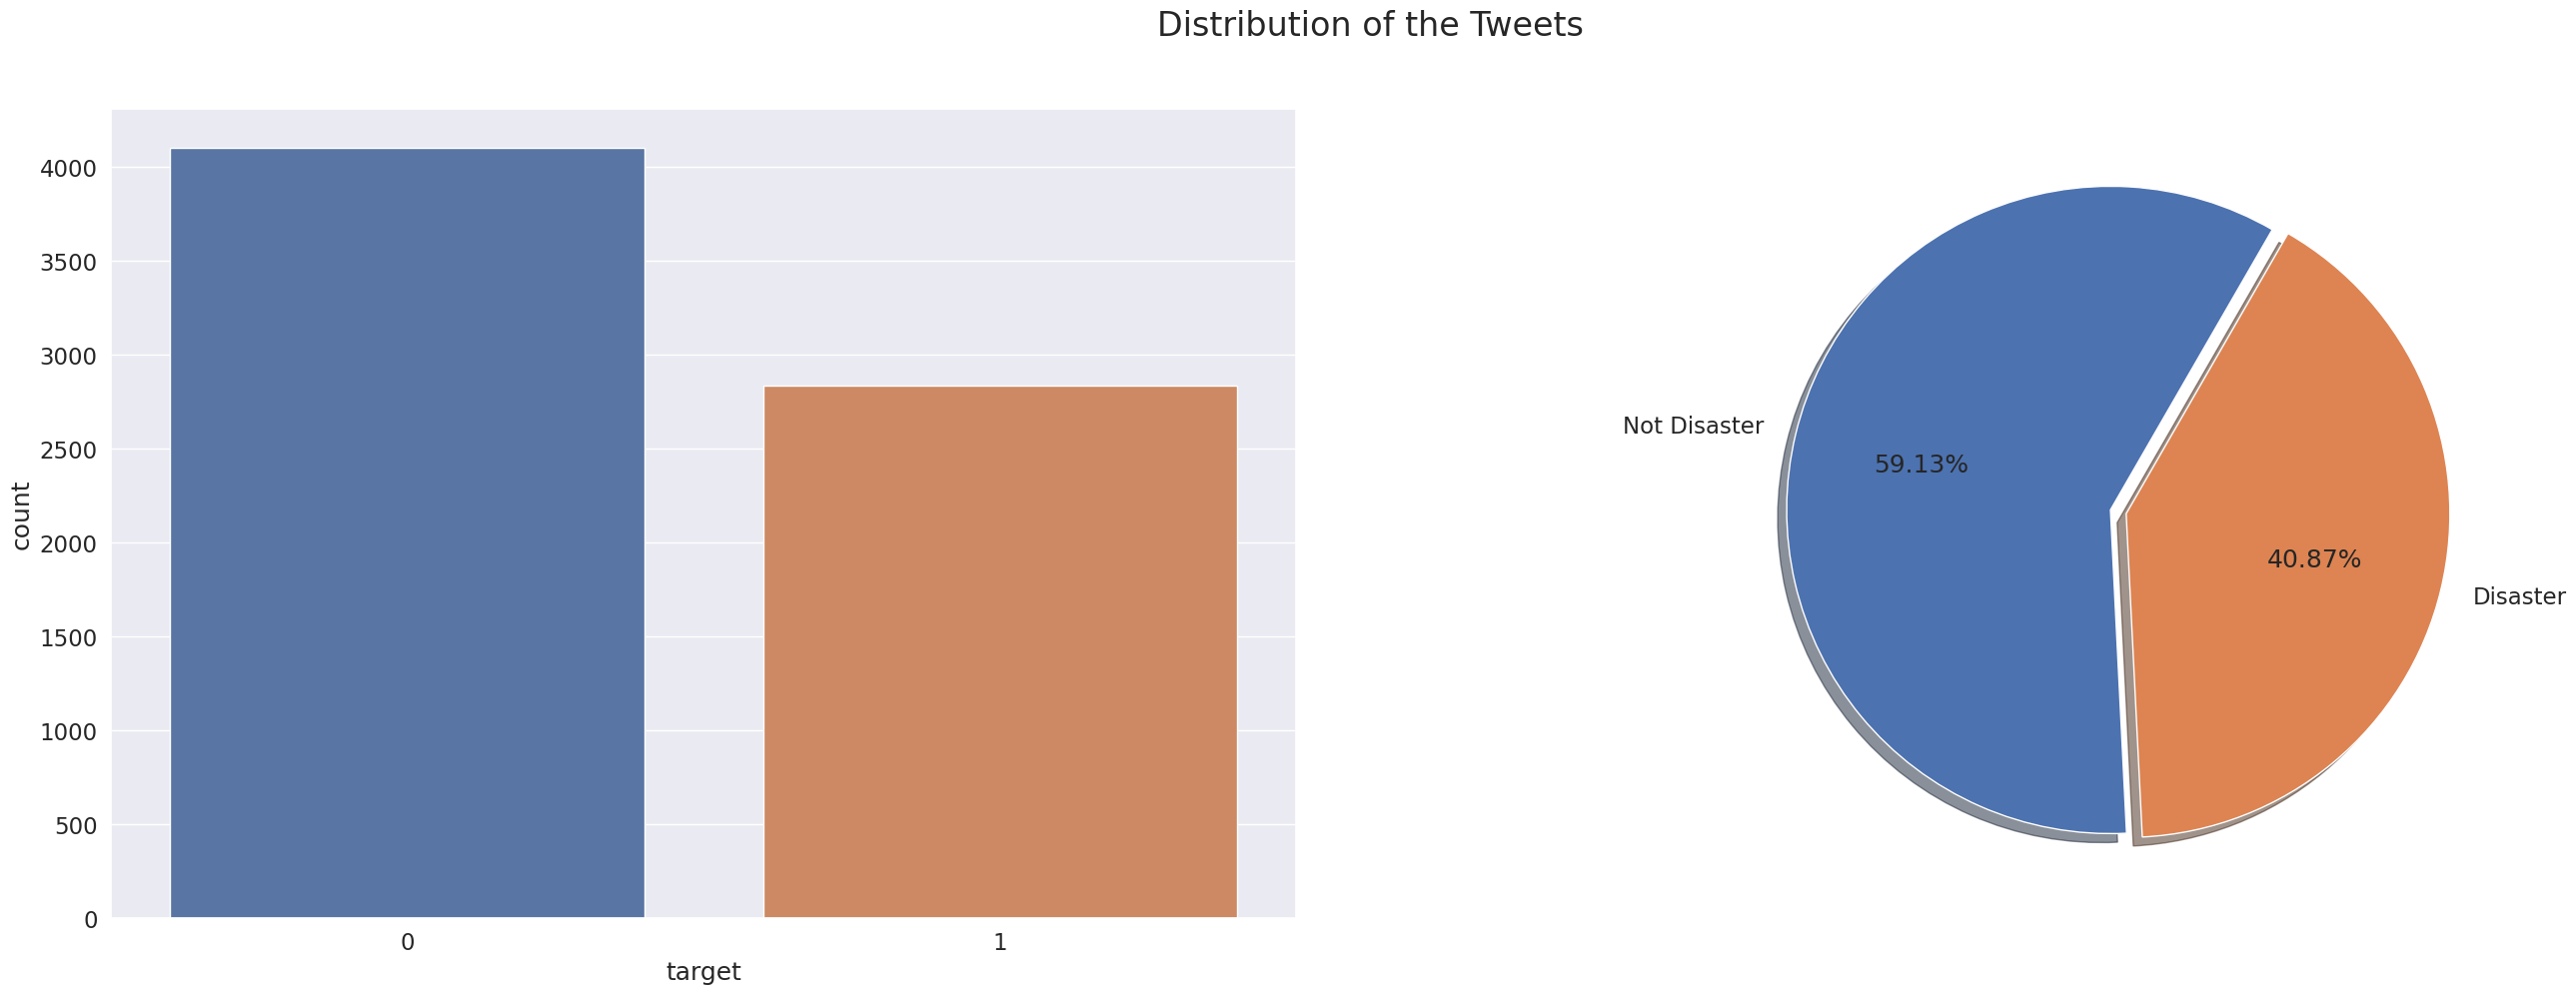

In [16]:
# Target distribution.

fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(30, 10), dpi=100)
sns.countplot(x=train['target'], ax=axes[0])
axes[1].pie(train['target'].value_counts(),
            labels=['Not Disaster', 'Disaster'],
            autopct='%1.2f%%',
            shadow=True,
            explode=(0.05, 0),
            startangle=60)
fig.suptitle('Distribution of the Tweets', fontsize=24)
plt.show()

In [18]:
# count the "target" Series group values
keyword = train.groupby("keyword")["target"].count()

keyword_df = pd.DataFrame(data={"keyword":keyword.index, "count":keyword.values}).sort_values(by=["count"],ascending=False)
keyword_df.head()

,keyword,count
104,fatalities,45
8,armageddon,42
63,deluge,42
57,damage,41
178,siren,40


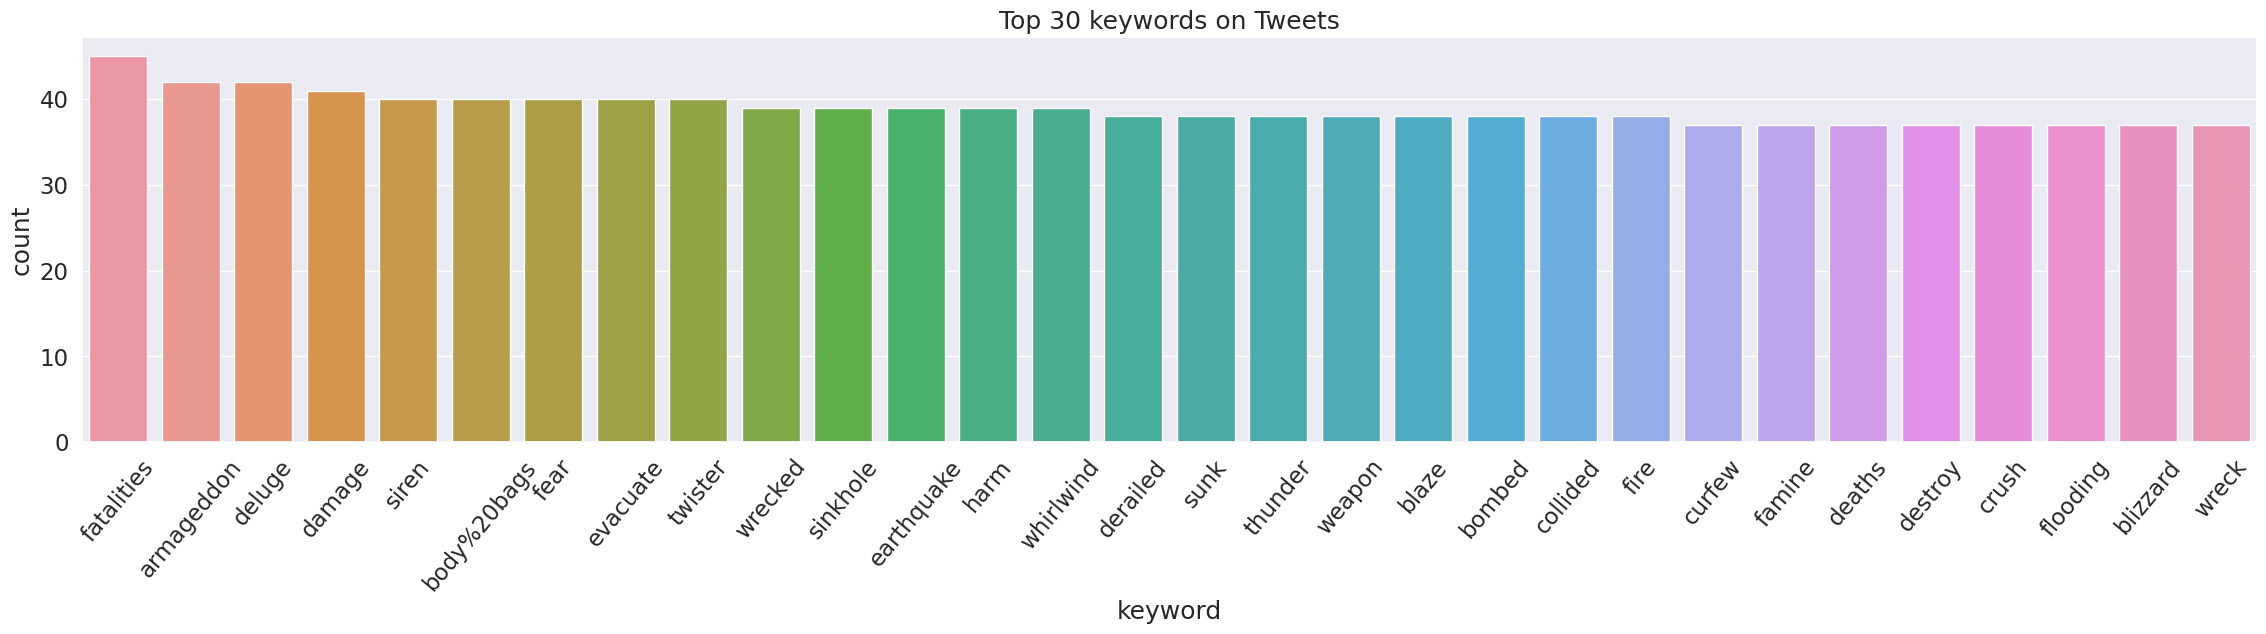

In [19]:
#Let's plot the "key" DataFrame
plt.figure(figsize=(25,5))
#Limit the data.head()
sns.barplot(data=keyword_df.head(30), x = 'keyword',y = 'count')
plt.xticks(rotation = 50)
plt.ylabel('count')
plt.title('Top 30 keywords on Tweets');

In [20]:
def check_max_length_sentence(df):
    max_length = 0
    for text in df["text"]:
        if len(text) > max_length:
            max_length = len(text)
    print("Maximum length of Text column is:",max_length)
    
    max_length = 0
    for text in df["location"]:
        if len(text) > max_length:
            max_length = len(text)
    print("Maximum length of Location column is:",max_length)
    
    max_length = 0
    for text in df["keyword"]:
        if len(text) > max_length:
            max_length = len(text)
    print("Maximum length of Keyword column is:",max_length)

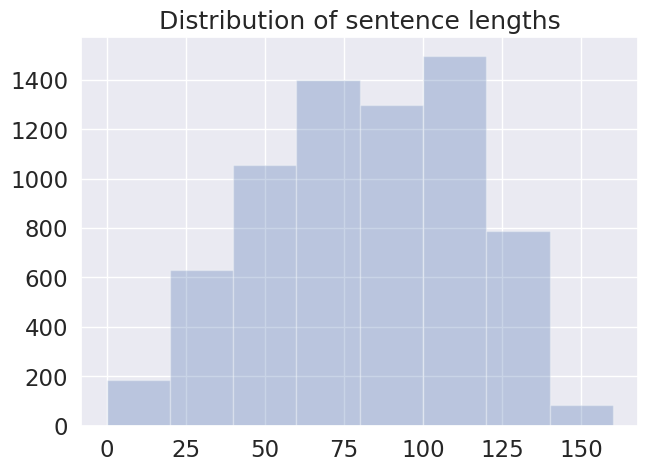

In [21]:
def get_sentence_lengths(df):
    df2 = pd.DataFrame(columns=["length"])
    i = 0
    for text in df["text"]:
        df2.loc[i,"length"] = len(text)
        i+=1
    return df2

def plot_sentence_lengths(df):
    lengths_df = get_sentence_lengths(df)
    bins = range(0,161,20)
    plt.hist(lengths_df["length"], bins=bins,alpha=0.3)
    #sns.countplot(data=lengths_df, x="length")
    plt.title("Distribution of sentence lengths")
    
plot_sentence_lengths(train)

# Building the BERT Model

In [22]:
# If there's a GPU available...

if torch.cuda.is_available():    
    # Tell PyTorch to use the GPU.     
    device = torch.device('cuda')   
    print('There are %d GPU(s) available.' % torch.cuda.device_count())
    print('We will use the GPU:', torch.cuda.get_device_name(0))
# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device('cpu')

There are 1 GPU(s) available.
We will use the GPU: Tesla P100-PCIE-16GB


In [23]:
labels = train['target'].values
idx = len(labels)
combined = pd.concat([train, test])
combined = combined.text.values

In [24]:
tokenizer = BertTokenizer.from_pretrained('bert-large-uncased', do_lower_case=True)

tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

In [25]:
# Print the original tweet.

print(' Original: ', combined[0])

# Print the tweet split into tokens.

print('Tokenized: ', tokenizer.tokenize(combined[0]))

# Print the sentence mapped to token ID's.

print('Token IDs: ', tokenizer.convert_tokens_to_ids(tokenizer.tokenize(combined[0])))

 Original:  Our Deeds are the Reason of this earthquake May ALLAH Forgive us all
Tokenized:  ['our', 'deeds', 'are', 'the', 'reason', 'of', 'this', 'earthquake', 'may', 'allah', 'forgive', 'us', 'all']
Token IDs:  [2256, 15616, 2024, 1996, 3114, 1997, 2023, 8372, 2089, 16455, 9641, 2149, 2035]


In [26]:
max_len = 0

# For every sentence...

for text in combined:

    # Tokenize the text and add `[CLS]` and `[SEP]` tokens.
    
    input_ids = tokenizer.encode(text, add_special_tokens=True)

    # Update the maximum sentence length.
    
    max_len = max(max_len, len(input_ids))

print('Max sentence length: ', max_len)

Max sentence length:  88


In [27]:
train= combined[:idx]
test = combined[idx:]
train.shape

(6936,)

In [28]:
def tokenize_map(sentence,labs='None'):
    
    """A function for tokenize all of the sentences and map the tokens to their word IDs."""
    
    global labels
    
    input_ids = []
    attention_masks = []

    # For every sentence...
    
    for text in sentence:
        #   "encode_plus" will:
        
        #   (1) Tokenize the sentence.
        #   (2) Prepend the `[CLS]` token to the start.
        #   (3) Append the `[SEP]` token to the end.
        #   (4) Map tokens to their IDs.
        #   (5) Pad or truncate the sentence to `max_length`
        #   (6) Create attention masks for [PAD] tokens.
        
        encoded_dict = tokenizer.encode_plus(
                            text,                      # Sentence to encode.
                            add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                            truncation='longest_first', # Activate and control truncation
                            max_length = 84,           # Max length according to our text data.
                            pad_to_max_length = True, # Pad & truncate all sentences.
                            return_attention_mask = True,   # Construct attn. masks.
                            return_tensors = 'pt',     # Return pytorch tensors.
                       )

        # Add the encoded sentence to the id list. 
        
        input_ids.append(encoded_dict['input_ids'])

        # And its attention mask (simply differentiates padding from non-padding).
        
        attention_masks.append(encoded_dict['attention_mask'])

    # Convert the lists into tensors.
    
    input_ids = torch.cat(input_ids, dim=0)
    attention_masks = torch.cat(attention_masks, dim=0)
    
    if labs != 'None': # Setting this for using this definition for both train and test data so labels won't be a problem in our outputs.
        labels = torch.tensor(labels)
        return input_ids, attention_masks, labels
    else:
        return input_ids, attention_masks

In [31]:
input_ids, attention_masks, labels = tokenize_map(train, labels)
test_input_ids, test_attention_masks= tokenize_map(test)

In [32]:
# Combine the training inputs into a TensorDataset.
dataset = TensorDataset(input_ids, attention_masks, labels)
# Create a 80-20 train-validation split.
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size

# Divide the dataset by randomly selecting samples.
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

print('{:>5,} training samples'.format(train_size))
print('{:>5,} validation samples'.format(val_size))

5,548 training samples
1,388 validation samples


In [33]:
# The DataLoader needs to know our batch size for training, so we specify it here. For fine-tuning BERT on a specific task, the authors recommend a batch size of 16 or 32.

batch_size = 16

# Create the DataLoaders for our training and validation sets.
# We'll take training samples in random order. 
train_dataloader = DataLoader(
            train_dataset,  # The training samples.
            sampler = RandomSampler(train_dataset), # Select batches randomly
            batch_size = batch_size # Trains with this batch size.
        )

# For validation the order doesn't matter, so we'll just read them sequentially.
validation_dataloader = DataLoader(
            val_dataset, # The validation samples.
            sampler = SequentialSampler(val_dataset), # Pull out batches sequentially.
            batch_size = batch_size # Evaluate with this batch size.
        )

In [34]:
prediction_data = TensorDataset(test_input_ids, test_attention_masks)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)

In [35]:
# Load BertForSequenceClassification, the pretrained BERT model with a single linear classification layer on top. 

model = BertForSequenceClassification.from_pretrained(
    'bert-large-uncased', # Use the 124-layer, 1024-hidden, 16-heads, 340M parameters BERT model with an uncased vocab.
    num_labels = 2, # The number of output labels--2 for binary classification. You can increase this for multi-class tasks.   
    output_attentions = False, # Whether the model returns attentions weights.
    output_hidden_states = False, # Whether the model returns all hidden-states.
)

# Tell pytorch to run this model on the device which we set GPU in our case.

model.to(device)

model.safetensors:   0%|          | 0.00/1.34G [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-large-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 1024, padding_idx=0)
      (position_embeddings): Embedding(512, 1024)
      (token_type_embeddings): Embedding(2, 1024)
      (LayerNorm): LayerNorm((1024,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-23): 24 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=1024, out_features=1024, bias=True)
              (key): Linear(in_features=1024, out_features=1024, bias=True)
              (value): Linear(in_features=1024, out_features=1024, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=1024, out_features=1024, bias=True)
              (LayerNorm): LayerNorm((1024,

In [36]:
# Get all of the model's parameters as a list of tuples:

params = list(model.named_parameters())

print('The BERT model has {:} different named parameters.\n'.format(len(params)))

print('==== Embedding Layer ====\n')

for p in params[0:5]:
    print('{:<55} {:>12}'.format(p[0], str(tuple(p[1].size()))))

print('\n==== First Transformer ====\n')

for p in params[5:21]:
    print('{:<55} {:>12}'.format(p[0], str(tuple(p[1].size()))))

print('\n==== Output Layer ====\n')

for p in params[-4:]:
    print('{:<55} {:>12}'.format(p[0], str(tuple(p[1].size()))))

The BERT model has 393 different named parameters.

==== Embedding Layer ====

bert.embeddings.word_embeddings.weight                  (30522, 1024)
bert.embeddings.position_embeddings.weight               (512, 1024)
bert.embeddings.token_type_embeddings.weight               (2, 1024)
bert.embeddings.LayerNorm.weight                             (1024,)
bert.embeddings.LayerNorm.bias                               (1024,)

==== First Transformer ====

bert.encoder.layer.0.attention.self.query.weight        (1024, 1024)
bert.encoder.layer.0.attention.self.query.bias               (1024,)
bert.encoder.layer.0.attention.self.key.weight          (1024, 1024)
bert.encoder.layer.0.attention.self.key.bias                 (1024,)
bert.encoder.layer.0.attention.self.value.weight        (1024, 1024)
bert.encoder.layer.0.attention.self.value.bias               (1024,)
bert.encoder.layer.0.attention.output.dense.weight      (1024, 1024)
bert.encoder.layer.0.attention.output.dense.bias             (

In [37]:
# Note: AdamW is a class from the huggingface library (as opposed to pytorch).

optimizer = AdamW(model.parameters(),
                  lr = 6e-6, # args.learning_rate
                  eps = 1e-8 # args.adam_epsilon
                )

In [38]:
# Number of training epochs. The BERT authors recommend between 2 and 4. 

epochs = 4
# Total number of training steps is [number of batches] x [number of epochs] (Note that this is not the same as the number of training samples).
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)

In [39]:
def flat_accuracy(preds, labels):
    
    """A function for calculating accuracy scores"""
    
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    
    return accuracy_score(labels_flat, pred_flat)

def flat_f1(preds, labels):
    
    """A function for calculating f1 scores"""
    
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    
    return f1_score(labels_flat, pred_flat)

In [40]:
def format_time(elapsed):    
    
    """A function that takes a time in seconds and returns a string hh:mm:ss"""
    
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [42]:
# This training code is based on the `run_glue.py` script here:
# https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L128

# We'll store a number of quantities such as training and validation loss, validation accuracy, f1 score and timings.
training_stats = []

# Measure the total training time for the whole run.
total_t0 = time.time()

# Total number of training steps
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps=0, 
                                            num_training_steps=total_steps)

# Store the predictions and true labels
all_true_labels = []
all_pred_labels = []

for epoch_i in range(0, epochs):
    # Perform one full pass over the training set.
    print('')
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # Measure how long the training epoch takes:
    t0 = time.time()

    # Reset the total loss for this epoch.
    total_train_loss = 0

    # Put the model into training mode. Don't be mislead--the call to `train` just changes the *mode*, it doesn't *perform* the training.
    
    # `dropout` and `batchnorm` layers behave differently during training vs. test ,
    # source: https://stackoverflow.com/questions/51433378/what-does-model-train-do-in-pytorch
    
    model.train()

    # For each batch of training data...
    for step, batch in enumerate(train_dataloader):

        # Progress update every 50 batches.
        if step % 50 == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)
            
            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the device(gpu in our case) using the `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device).to(torch.int64)
        b_input_mask = batch[1].to(device).to(torch.int64)
        b_labels = batch[2].to(device).to(torch.int64)

        # Always clear any previously calculated gradients before performing a backward pass. PyTorch doesn't do this automatically because accumulating the gradients is 'convenient while training RNNs'. 
        # Source: https://stackoverflow.com/questions/48001598/why-do-we-need-to-call-zero-grad-in-pytorch 
        model.zero_grad()        

        # Perform a forward pass (evaluate the model on this training batch).
        # The documentation for this `model` function is down here: 
        # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers BertForSequenceClassification.
        
        # It returns different numbers of parameters depending on what arguments given and what flags are set. For our useage here, it returns the loss (because we provided labels),
        # And the 'logits' (the model outputs prior to activation.)
        
        # Forward pass
        outputs = model(b_input_ids, 
                        token_type_ids=None, 
                        attention_mask=b_input_mask, 
                        labels=b_labels)

        # Accumulate the training loss over all of the batches so that we can calculate the average loss at the end, 
        # `loss` is a tensor containing a single value; the `.item()` function just returns the Python value from the tensor.
        # Extract the loss and logits from the model outputs
        loss = outputs.loss
        logits = outputs.logits
        total_train_loss += loss.item()
        
        # Perform a backward pass to calculate the gradients.  
        loss.backward()

        # Clip the norm of the gradients to 1.0 This is to help prevent the 'exploding gradients' problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Update parameters and take a step using the computed gradient.
        
        # The optimizer dictates the 'update rule'(How the parameters are modified based on their gradients, the learning rate, etc.)
        optimizer.step()
        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over all of the batches.
    avg_train_loss = total_train_loss / len(train_dataloader)            
    
    # Measure how long this epoch took. 
    training_time = format_time(time.time() - t0)

    print('')
    print('  Average training loss: {0:.2f}'.format(avg_train_loss))
    print('  Training epcoh took: {:}'.format(training_time))
        
    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on our validation set.
    print('')
    print('Running Validation...')

    t0 = time.time()

    # Put the model in evaluation mode--the dropout layers behave differently during evaluation. 
    model.eval()

    # Tracking variables:    
    total_eval_accuracy = 0
    total_eval_loss = 0
    total_eval_f1 = 0
    nb_eval_steps = 0
    
    # Tracking variables for precision and recall
    true_labels = []
    pred_labels = []

    # Evaluate data for one epoch.
    
    for batch in validation_dataloader:
        
        # Unpack this training batch from our dataloader. 
        
        # As we unpack the batch, we'll also copy each tensor to the GPU using the `to` method.
        
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        
        # Tell pytorch not to bother with constructing the compute graph during the forward pass, since this is only needed for backprop (training part).      
        with torch.no_grad():        
            # Forward pass, calculate logit predictions.
            # token_type_ids is the same as the 'segment ids', which differentiates sentence 1 and 2 in 2-sentence tasks.
            # The documentation for this `model` function is down here: 
            # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers BertForSequenceClassification.
            # Get the 'logits' output by the model. The 'logits' are the output values prior to applying an activation function like the softmax.
            
            outputs = model(b_input_ids, 
                        token_type_ids=None, 
                        attention_mask=b_input_mask,
                        labels=b_labels)
            
        # Accumulate the validation loss.
        loss = outputs.loss
        logits = outputs.logits

        total_eval_loss += loss.item()

        # Move logits and labels to CPU:
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        
        # Save the true and predicted labels for calculating the confusion matrix
        true_labels.extend(label_ids)
        pred_labels.extend(np.argmax(logits, axis=1))

        # Calculate the accuracy for this batch of test sentences, and accumulate it over all batches:
        total_eval_accuracy += flat_accuracy(logits, label_ids)
        total_eval_f1 += flat_f1(logits, label_ids)
        

    # Report the final accuracy for this validation run.    
    avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
    print('  Accuracy: {0:.2f}'.format(avg_val_accuracy))
    
    # Report the final f1 score for this validation run.
    avg_val_f1 = total_eval_f1 / len(validation_dataloader)
    print('  F1: {0:.2f}'.format(avg_val_f1))

    # Calculate the average loss over all of the batches.  
    avg_val_loss = total_eval_loss / len(validation_dataloader)
    
    
    
    # Measure how long the validation run took:
    validation_time = format_time(time.time() - t0)
    
    print('  Validation Loss: {0:.2f}'.format(avg_val_loss))
    print('  Validation took: {:}'.format(validation_time))

    # Record all statistics from this epoch.
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Valid. Accur.': avg_val_accuracy,
            'Val_F1' : avg_val_f1,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

print('')
print('Training complete!')

print('Total training took {:} (h:mm:ss)'.format(format_time(time.time()-total_t0)))


======== Epoch 1 / 4 ========
Training...
  Batch    50  of    347.    Elapsed: 0:00:23.
  Batch   100  of    347.    Elapsed: 0:00:45.
  Batch   150  of    347.    Elapsed: 0:01:08.
  Batch   200  of    347.    Elapsed: 0:01:31.
  Batch   250  of    347.    Elapsed: 0:01:54.
  Batch   300  of    347.    Elapsed: 0:02:16.

  Average training loss: 0.36
  Training epcoh took: 0:02:38

Running Validation...
  Accuracy: 0.85
  F1: 0.80
  Validation Loss: 0.38
  Validation took: 0:00:12

======== Epoch 2 / 4 ========
Training...
  Batch    50  of    347.    Elapsed: 0:00:23.
  Batch   100  of    347.    Elapsed: 0:00:45.
  Batch   150  of    347.    Elapsed: 0:01:08.
  Batch   200  of    347.    Elapsed: 0:01:31.
  Batch   250  of    347.    Elapsed: 0:01:54.
  Batch   300  of    347.    Elapsed: 0:02:17.

  Average training loss: 0.27
  Training epcoh took: 0:02:38

Running Validation...
  Accuracy: 0.85
  F1: 0.80
  Validation Loss: 0.45
  Validation took: 0:00:12

======== Epoch 3 / 4 

In [40]:
pd.set_option('display.precision', 2)
df_stats = pd.DataFrame(data=training_stats)

# Use the 'epoch' as the row index
df_stats = df_stats.set_index('epoch')

display(df_stats)

,Training Loss,Valid. Loss,Valid. Accur.,Val_F1,Training Time,Validation Time
epoch,,,,,,
1,0.49,0.38,0.85,0.78,0:02:38,0:00:12
2,0.36,0.39,0.85,0.81,0:02:38,0:00:12
3,0.29,0.42,0.85,0.80,0:02:38,0:00:12
4,0.24,0.45,0.85,0.80,0:02:38,0:00:12


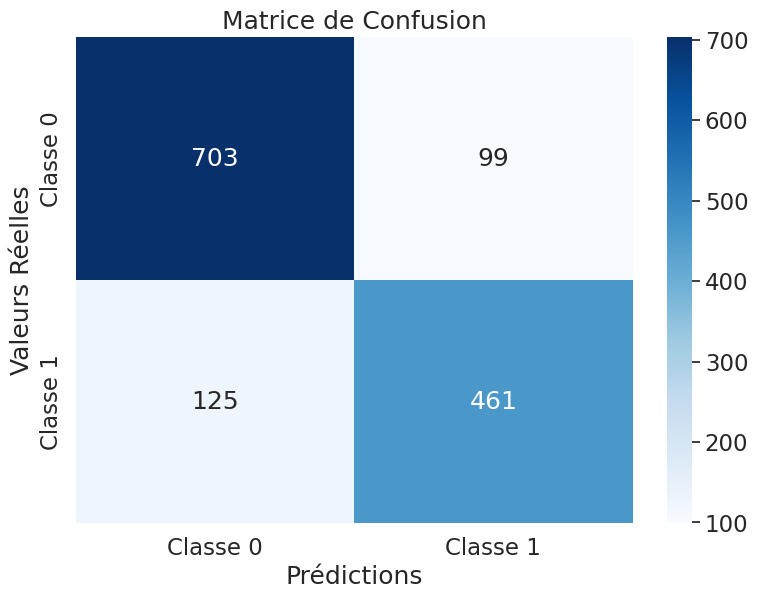

Precision: 0.8232
Recall: 0.7867


In [46]:
conf_matrix = confusion_matrix(true_labels, pred_labels)
precision = precision_score(true_labels, pred_labels)
recall = recall_score(true_labels, pred_labels)

# Save the confusion matrix and classification report in training_stats
training_stats[-1].update({'Confusion Matrix': conf_matrix.tolist(), 'Precision': precision, 'Recall': recall})

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues', xticklabels=['Classe 0', 'Classe 1'], yticklabels=['Classe 0', 'Classe 1'])
plt.xlabel('Prédictions')
plt.ylabel('Valeurs Réelles')
plt.title('Matrice de Confusion')
plt.savefig('/kaggle/working/matrice_de_confusion.png')
plt.show()


print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')

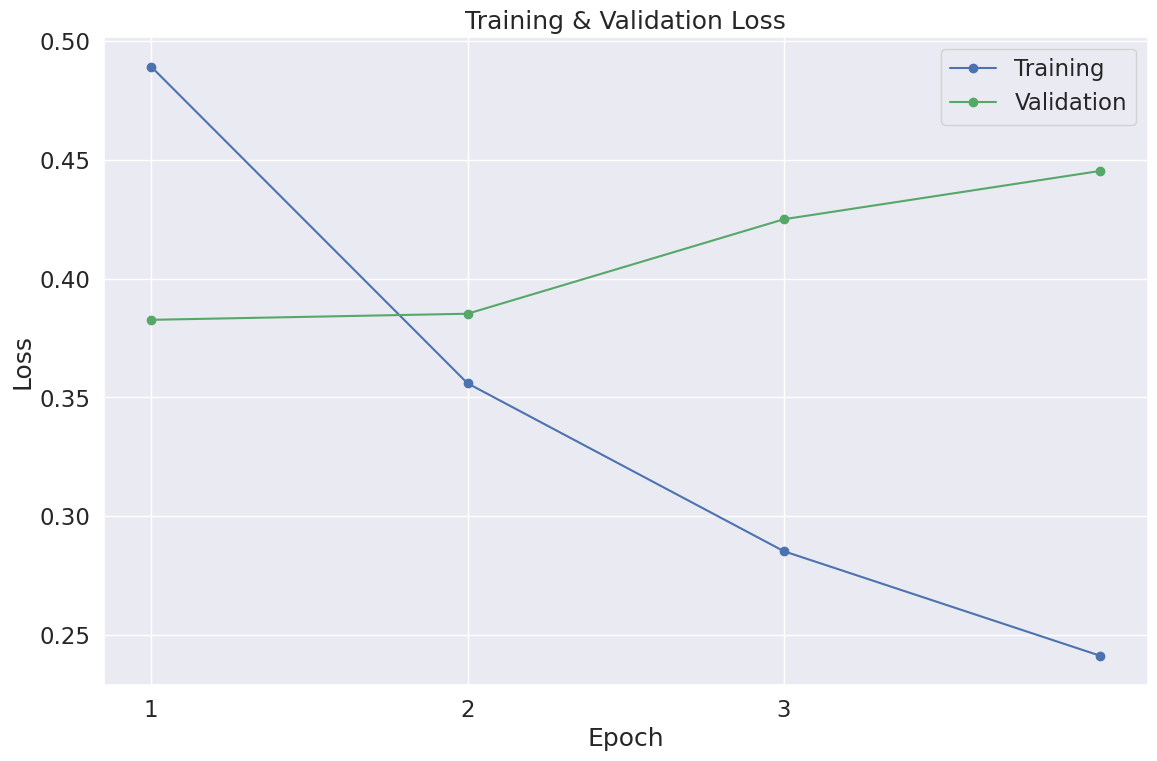

In [50]:
fig, axes = plt.subplots(figsize=(12,8))

# Plot the learning curve:
plt.plot(df_stats['Training Loss'], 'b-o', label='Training')
plt.plot(df_stats['Valid. Loss'], 'g-o', label='Validation')

# Label the plot:
plt.title('Training & Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.legend()
plt.xticks([1, 2, 3])

plt.show()

In [51]:
# Prediction on test set:
print('Predicting labels for {:,} test sentences...'.format(len(test_input_ids)))

# Put model in evaluation mode:
model.eval()

# Tracking variables :
predictions = []

# Predict:
for batch in prediction_dataloader:
  # Add batch to GPU
  batch = tuple(t.to(device) for t in batch)
  # Unpack the inputs from our dataloader:
  b_input_ids, b_input_mask, = batch
  # Telling the model not to compute or store gradients, saving memory and speeding up prediction
  with torch.no_grad():
      # Forward pass, calculate logit predictions: 
      outputs = model(b_input_ids, token_type_ids=None, 
                      attention_mask=b_input_mask)
        
  logits = outputs[0]
  # Move logits and labels to CPU:
  logits = logits.detach().cpu().numpy()
  # Store predictions and true labels:
  predictions.append(logits)
print('    DONE.')

Predicting labels for 3,263 test sentences...
    DONE.


In [53]:
# Getting list of predictions and then choosing the target value with using argmax on probabilities.

flat_predictions = [item for sublist in predictions for item in sublist]
flat_predictions = np.argmax(flat_predictions, axis=1).flatten()

In [54]:
# Submission data.

submission = pd.read_csv('/kaggle/input/nlp-getting-started/sample_submission.csv')
submission['target'] = flat_predictions
submission.head(10)

,id,target
0,0,1
1,2,1
2,3,1
3,9,1
4,11,1
5,12,1
6,21,0
7,22,0
8,27,0
9,29,0


In [57]:
submission.to_csv('submission.csv', index=False)